<a href="https://colab.research.google.com/github/Joshithasree/Brain_tumor_segmenttion_and_survival_prediction_using_deep_learning/blob/main/All_models_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/')

In [ ]:
!pip install SimpleITK
import SimpleITK as sitk 

     |████████████████████████████████| 51.7 MB 146 kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Importing necessary packages**

In [ ]:
from tqdm import tqdm
import numpy as np

from keras.utils.np_utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,add,Input,Dropout,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda,PReLU,concatenate,AveragePooling2D
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Nadam
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
from keras import regularizers
from keras import backend as K
import keras as ke
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as sk
import skimage.io as io
import skimage.transform as trans

## **Loading the data**

In [ ]:
path = '/content/drive/MyDrive/HGG/HGG1/'

In [ ]:
import csv
#import pickle

#from joblib import dump

age_dict = {}
days_dict = {}
path1 = '/content/survival_data.csv'

def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

with open(path1, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    line_count = 0
   
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            
            line_count+=1

    print(f'Processed {line_count} lines.')
    #age_m = np.zeros((1,1))
    
    
    

Column names are BraTS18ID, Age, Survival, ResectionStatus
['Brats18_TCIA08_167_1', '74.907', '153', 'NA']
['Brats18_TCIA08_242_1', '66.479', '147', 'NA']
['Brats18_TCIA08_319_1', '64.86', '254', 'NA']
['Brats18_TCIA08_469_1', '63.899', '519', 'NA']
['Brats18_TCIA08_218_1', '57.345', '346', 'NA']
['Brats18_TCIA08_406_1', '78.745', '82', 'NA']
['Brats18_TCIA08_280_1', '57.362', '508', 'NA']
['Brats18_TCIA08_105_1', '66.627', '77', 'NA']
['Brats18_TCIA08_278_1', '50.501', '1458', 'NA']
['Brats18_TCIA06_247_1', '76.699', '244', 'NA']
['Brats18_TCIA06_372_1', '74.521', '213', 'NA']
['Brats18_TCIA06_165_1', '51.756', '5', 'NA']
['Brats18_TCIA06_409_1', '69.266', '99', 'NA']
['Brats18_TCIA06_184_1', '61.167', '434', 'NA']
['Brats18_TCIA05_277_1', '70.367', '232', 'NA']
['Brats18_TCIA05_478_1', '59.255', '30', 'NA']
['Brats18_TCIA04_437_1', '46.953', '333', 'NA']
['Brats18_TCIA04_361_1', '75.973', '476', 'NA']
['Brats18_TCIA04_192_1', '75.962', '121', 'NA']
['Brats18_TCIA04_479_1', '56.4', '3

In [ ]:
def load_data(path):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  age=[]
  days=[]
  count=0
  
  for p in tqdm(my_dir):
    
    data_list = sorted(os.listdir(path+p))
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    if p in age_dict.keys():
      data.append([flair,t1,t1ce,t2])
      gt.append(seg)
      age.append(age_dict[p])
      days.append(days_dict[p])
      count+=1
    if(count==20):
      break
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  age=np.asarray(age,dtype=np.float32)
  days=np.asarray(days,dtype=np.uint8)
  return data,gt,age,days

In [ ]:
#HGG
data,gt,age,days = load_data(path) 

 74%|███████▍  | 37/50 [02:38<00:55,  4.28s/it]


In [ ]:
data.shape,gt.shape,age.shape,days.shape,data.dtype,gt.dtype,age.dtype,days.dtype

((20, 4, 155, 240, 240),
 (20, 155, 240, 240),
 (20,),
 (20,),
 dtype('float32'),
 dtype('uint8'),
 dtype('float32'),
 dtype('uint8'))

In [ ]:
r=[]
for i in age:
  r=r+[i]*90
age=np.asarray(r)

In [ ]:
r=[]
for i in days:
  r=r+[i]*90
days=np.asarray(r)

In [ ]:
print(len(age),len(days))

1800 1800


In [ ]:
print(len(set(age)),len(set(days)))

20 20


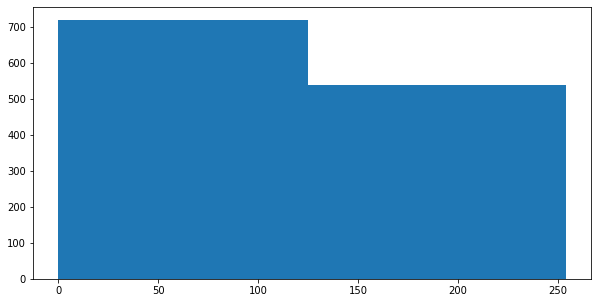

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
 
 
# Creating dataset
a = np.array(days)
 
# Creating histogram
fig, ax = plt.subplots(figsize =(10,5))
ax.hist(a, bins = [0, 125, 200, 254])
 
# Show plot
plt.show()

In [ ]:
for i in range(len(days)):
  if days[i]<125:
    days[i]=0
  elif days[i]>=125 and days[i]<200:
    days[i]=1
  else:
    days[i]=2

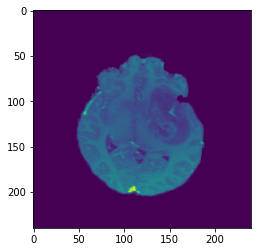

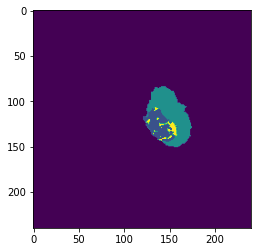

In [ ]:
plt.imshow(data[0,2,65,:,:])
plt.show()
plt.imshow(gt[0,65,:,:])
plt.show()

In [ ]:
data = np.transpose(data,(0,2,3,4,1))

In [ ]:
data.shape,gt.shape,data.dtype,gt.dtype

((20, 155, 240, 240, 4), (20, 155, 240, 240), dtype('float32'), dtype('uint8'))

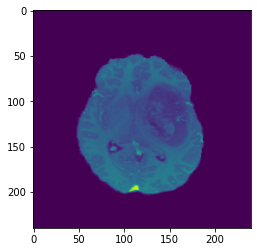

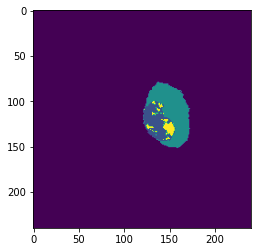

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data[0,70,:,:,2])
plt.show()
plt.imshow(gt[0,70,:,:])
plt.show()

# **Data Preprocessing**

In [ ]:
data.shape,gt.shape

((20, 155, 240, 240, 4), (20, 155, 240, 240))

In [ ]:
data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])   #taking 30-120 slices
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

In [ ]:
data.shape,gt.shape

((1800, 192, 192, 4), (1800, 192, 192, 1))

In [ ]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

# **Combining the gt,age and days features**

In [ ]:
l=[]
for i in range(len(gt)):
  r=[]
  r.append(gt[i])
  r.append(age[i])
  r.append(days[i])
  l.append(r)
print(l[900])

[array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8), 56.419, 1]


# **Train-Test Split**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, l, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

# **For training dataset**

In [ ]:
age_train=[]
days_train=[]

for i in range(len(Y_train)):
  age_train.append(Y_train[i][1])
  days_train.append(Y_train[i][2])
  Y_train[i]=Y_train[i][0]

print(Y_train[0],age_train[0],days_train[0])

[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]] 56.419 1


In [ ]:
age_train=np.asarray(age_train)
days_train=np.asarray(days_train)
Y_train=np.asarray(Y_train)

In [ ]:
print(age_train.shape,Y_train.shape,days_train.shape)

(1080,) (1080, 192, 192, 1) (1080,)


# **For validation dataset**

In [ ]:
age_val=[]
days_val=[]

for i in range(len(Y_val)):
  age_val.append(Y_val[i][1])
  days_val.append(Y_val[i][2])
  Y_val[i]=Y_val[i][0]

print(Y_val[0],age_val[0],days_val[0])

[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]] 54.301 2


In [ ]:
age_val=np.asarray(age_val)
days_val=np.asarray(days_val)
Y_val=np.asarray(Y_val)

In [ ]:
print(age_val.shape,Y_val.shape,days_val.shape)

(360,) (360, 192, 192, 1) (360,)


# **For test dataset**

In [ ]:
age_test=[]
days_test=[]

for i in range(len(Y_test)):
  age_test.append(Y_test[i][1])
  days_test.append(Y_test[i][2])
  Y_test[i]=Y_test[i][0]

print(Y_test[0],age_test[0],days_test[0])

[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]] 55.759 0


In [ ]:
age_test=np.asarray(age_test)
days_test=np.asarray(days_test)
Y_test=np.asarray(Y_test)

In [ ]:
print(age_test.shape,Y_test.shape,days_test.shape,X_test.shape)

(360,) (360, 192, 192, 1) (360,) (360, 192, 192, 4)


# **Building the model**

In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [ ]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((1080, 192, 192, 4),
 (1080, 192, 192, 4),
 (360, 192, 192, 4),
 (360, 192, 192, 4),
 (360, 192, 192, 4),
 (360, 192, 192, 1))

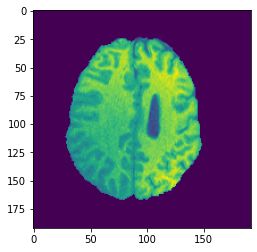

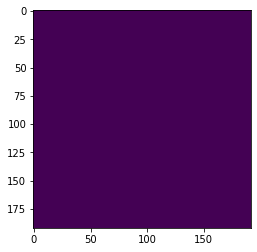

In [ ]:
plt.imshow(X_train[0,:,:,1])
plt.show()
plt.imshow(Y_train[0,:,:,1])
plt.show()

In [ ]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((1080, 192, 192, 4),
 (1080, 192, 192, 4),
 (360, 192, 192, 4),
 (360, 192, 192, 4))

# **2-D VNet model**

In [ ]:

def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
  

In [ ]:
def resBlock(conv,stage,keep_prob,stage_num=5):
    inputs=conv
    
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([inputs,conv]))
    conv_drop=Dropout(keep_prob)(conv_add)
    
    if stage<stage_num:
        conv_downsample=PReLU()(BatchNormalization()(Conv2D(16*(2**stage), 2, strides=(2, 2),activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv_drop)))
        return conv_downsample,conv_add
    else:
        return conv_add,conv_add
         
def up_resBlock(forward_conv,input_conv,stage):
    conv=concatenate([forward_conv,input_conv],axis = -1)
  
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
    conv_add=PReLU()(add([input_conv,conv]))
    if stage>1:
        conv_upsample=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(stage-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

def vnet(pretrained_weights = None,input_size = (192,192,4),num_class=1,is_training=True,stage_num=5,thresh=0.5):
    keep_prob = 0.1
    features=[]
    input_model = Input(input_size)
    x=PReLU()(BatchNormalization()(Conv2D(16, 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(input_model)))
    
    for s in range(1,stage_num+1):
        x,feature=resBlock(x,s,keep_prob,stage_num)
        features.append(feature)
        
    conv_up=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(s-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(x)))
    
    for d in range(stage_num-1,0,-1):
        conv_up=up_resBlock(features[d-1],conv_up,d)
    if num_class>1:
        conv_out=Conv2D(num_class, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    else:
        conv_out=Conv2D(num_class, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    
    
    
    
    model=Model(inputs=input_model,outputs=conv_out)    

    model.compile(optimizer = Nadam(lr = 2e-4),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model
model_v=vnet(input_size = (192,192,4),num_class=4,stage_num=5)
model_v.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 192, 192, 16  1616        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 192, 192, 16  64         ['conv2d_27[0][0]']              
 ormalization)                  )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


                                                                                                  
 p_re_lu_51 (PReLU)             (None, 24, 24, 128)  73728       ['batch_normalization_39[0][0]'] 
                                                                                                  
 conv2d_37 (Conv2D)             (None, 24, 24, 128)  409728      ['p_re_lu_51[0][0]']             
                                                                                                  
 batch_normalization_40 (BatchN  (None, 24, 24, 128)  512        ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 p_re_lu_52 (PReLU)             (None, 24, 24, 128)  73728       ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_38

In [ ]:
checkpointer_v = callbacks.ModelCheckpoint(filepath = 'vnet-weights.hdf5',save_best_only=True)
training_log_v = callbacks.TensorBoard(log_dir='./Model_logs')

In [ ]:
history = model_v.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=10,callbacks=[training_log_v,checkpointer_v],shuffle=True)

Epoch 1/10
135/135 [==============================] - 1353s 10s/step - loss: 0.2575 - dice_coef: 0.7425 - accuracy: 0.8182 - val_loss: 0.2727 - val_dice_coef: 0.7273 - val_accuracy: 0.9086
Epoch 2/10
135/135 [==============================] - 1365s 10s/step - loss: 0.0833 - dice_coef: 0.9167 - accuracy: 0.9733 - val_loss: 0.0932 - val_dice_coef: 0.9068 - val_accuracy: 0.9758
Epoch 3/10
135/135 [==============================] - 1311s 10s/step - loss: 0.0420 - dice_coef: 0.9580 - accuracy: 0.9808 - val_loss: 0.0424 - val_dice_coef: 0.9576 - val_accuracy: 0.9826
Epoch 4/10
135/135 [==============================] - 1317s 10s/step - loss: 0.0286 - dice_coef: 0.9714 - accuracy: 0.9828 - val_loss: 0.0268 - val_dice_coef: 0.9732 - val_accuracy: 0.9847
Epoch 5/10
135/135 [==============================] - 1361s 10s/step - loss: 0.0225 - dice_coef: 0.9775 - accuracy: 0.9842 - val_loss: 0.0214 - val_dice_coef: 0.9786 - val_accuracy: 0.9856
Epoch 6/10
135/135 [==============================] - 1

In [ ]:
model_v.save('Vnet-model.h5')

No handles with labels found to put in legend.


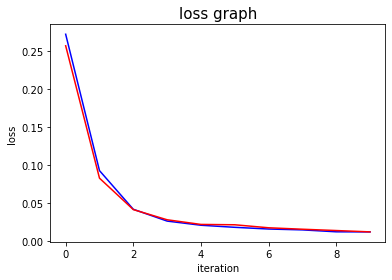

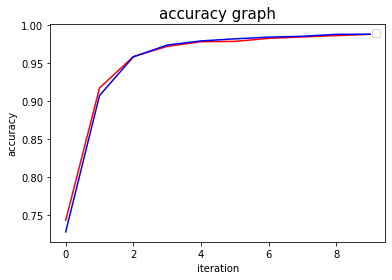

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.legend()
plt.show()



In [ ]:
Y_test_encod = to_categorical(Y_test)

In [ ]:
train_result = model_v.evaluate(X_train,Y_train,verbose=0)
test_result = model_v.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model_v.evaluate(X_val,Y_val,verbose=0)

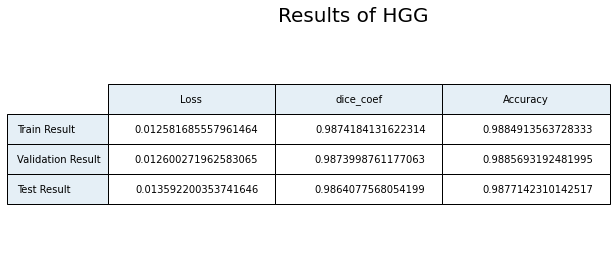

In [ ]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

UNet Model - With Additive Skip Connections


In [ ]:
#encoder

inputs = Input(shape=(192,192,4),name='input')  

block0_conv1 = Conv2D(32,3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_conv2 = Conv2D(32,3,padding='same',activation='relu',name='block0_conv2')(block0_conv1)
block0_norm = BatchNormalization(name='block0_batch_norm')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm,up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm,up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm,up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model_u = Model(inputs = inputs, outputs = output)
model_u.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block0_conv1 (Conv2D)          (None, 192, 192, 32  1184        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block0_conv2 (Conv2D)          (None, 192, 192, 32  9248        ['block0_conv1[0][0]']           
                                )                                                           

In [ ]:
model_u.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model_u.save_weights('unet-weights.hdf5')
checkpointer_u = callbacks.ModelCheckpoint(filepath = 'unet-weights.hdf5',save_best_only=True)
training_log_u = callbacks.TensorBoard(log_dir='./Model_logs')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_u = model_u.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=10,callbacks=[training_log_u,checkpointer_u],shuffle=True)

Epoch 1/10
135/135 [==============================] - 923s 7s/step - loss: 0.5935 - dice_coef: 0.4065 - accuracy: 0.3877 - val_loss: 0.5947 - val_dice_coef: 0.4053 - val_accuracy: 0.7110
Epoch 2/10
135/135 [==============================] - 891s 7s/step - loss: 0.0923 - dice_coef: 0.9077 - accuracy: 0.9482 - val_loss: 0.0538 - val_dice_coef: 0.9462 - val_accuracy: 0.9749
Epoch 3/10
135/135 [==============================] - 882s 7s/step - loss: 0.0266 - dice_coef: 0.9734 - accuracy: 0.9740 - val_loss: 0.0269 - val_dice_coef: 0.9731 - val_accuracy: 0.9753
Epoch 4/10
135/135 [==============================] - 886s 7s/step - loss: 0.0261 - dice_coef: 0.9739 - accuracy: 0.9741 - val_loss: 0.0250 - val_dice_coef: 0.9750 - val_accuracy: 0.9753
Epoch 5/10
135/135 [==============================] - 885s 7s/step - loss: 0.0260 - dice_coef: 0.9740 - accuracy: 0.9741 - val_loss: 0.0248 - val_dice_coef: 0.9752 - val_accuracy: 0.9754
Epoch 6/10
135/135 [==============================] - 896s 7s/ste

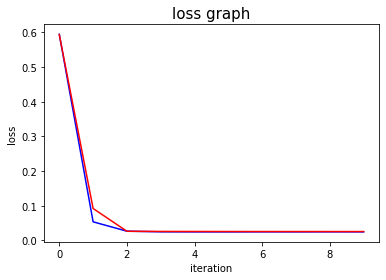

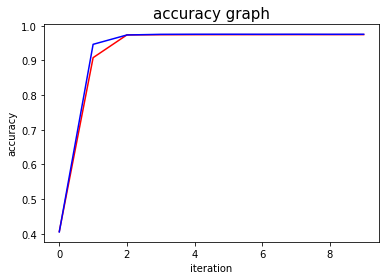

In [ ]:
a = history_u.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
train_result = model_u.evaluate(X_train,Y_train,verbose=0)
test_result = model_u.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model_u.evaluate(X_val,Y_val,verbose=0)

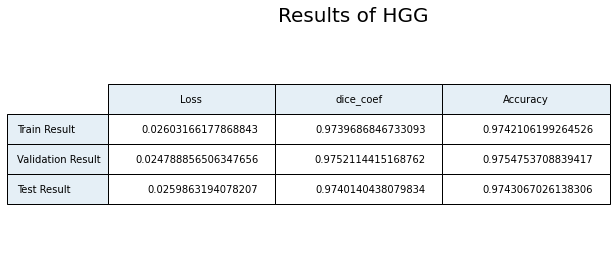

In [ ]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [ ]:
model_u.save('unet-model.h5')

# **Integrating with the survival prediction model**

**Survival Prediction model**

In [ ]:
def SurvPredNet(input_img,age_m):
    input_img = BatchNormalization()(input_img)
    a1 = Conv2D(16,kernel_size = (3,3))(input_img)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(24,kernel_size = (3,3))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    #a1 = AveragePooling2D(pool_size = (6,6) , strides = (1,1))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    #a1 = AveragePooling2D(pool_size = (5,5) , strides = (1,1))(a1)
    a1 = Conv2D(32,kernel_size = (3,3))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
   # a1 = AveragePooling2D(pool_size = (6,6) , strides = (1,1))(a1)
    
    a1 = Flatten()(a1)
    a1 = concatenate([a1,age_m])
    a1 = BatchNormalization()(a1)
    
    a1 = Dense(32,activation = 'relu')(a1)
    a1 = Dense(16,activation = 'relu')(a1)
    outputs = Dense(3,activation = 'softmax')(a1)
    
    model = Model(inputs = [input_img,age_m] , outputs = outputs)
    
    return model

In [ ]:
input_img = Input((192,192,1))
age_m = Input((1))
model_surv = SurvPredNet(input_img,age_m)
model_surv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_surv.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 190, 190, 16  160         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_61 (BatchN  (None, 190, 190, 16  64         ['conv2d_54[1][0]']              
 ormalization)                  )                                                           

In [ ]:
days_test_enc=to_categorical(days_test)

In [ ]:
days_test_enc.shape

(360, 3)

In [ ]:
days_train_enc=to_categorical(days_train)

In [ ]:
days_train_enc.shape

(1080, 3)

In [ ]:
from keras.models import load_model
seg=load_model('vnet-model.h5' , custom_objects = {'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
pre = np.argmax(seg.predict(X_train),axis=-1)

In [ ]:
np.unique(pre)

array([0, 1, 2])

In [ ]:
pre.shape

(1080, 192, 192)

In [ ]:
pred=pre.reshape(-1,192,192,1)

In [ ]:
pred.shape

(1080, 192, 192, 1)

X_test 0


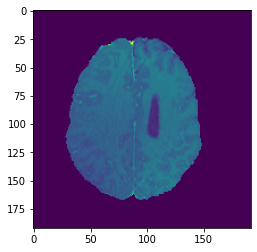

Predicted 0


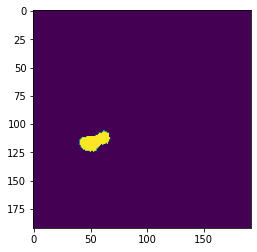

Actual 0


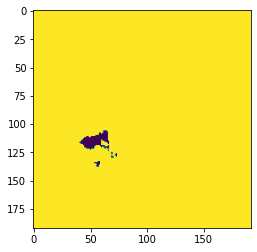

X_test 1


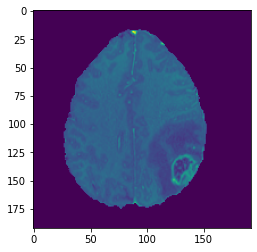

Predicted 1


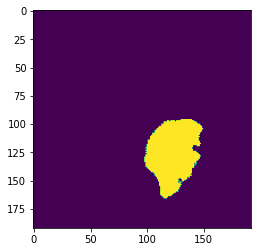

Actual 1


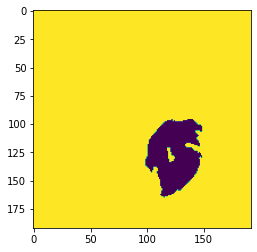

X_test 2


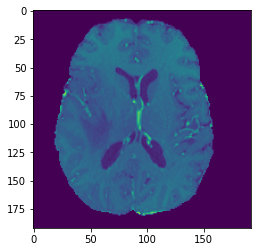

Predicted 2


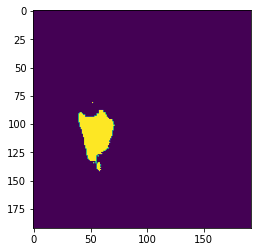

Actual 2


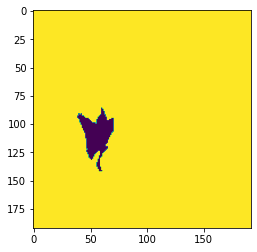

X_test 3


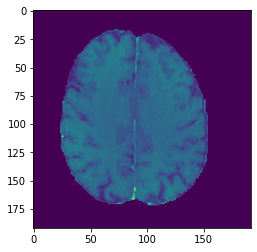

Predicted 3


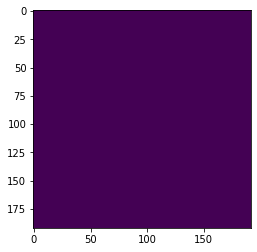

Actual 3


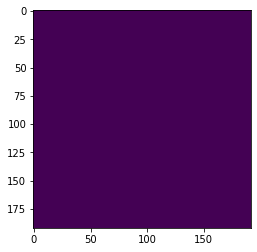

X_test 4


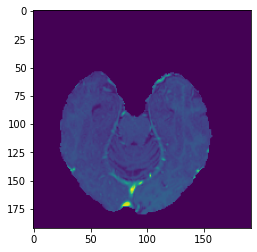

Predicted 4


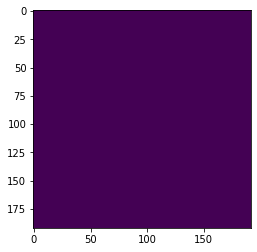

Actual 4


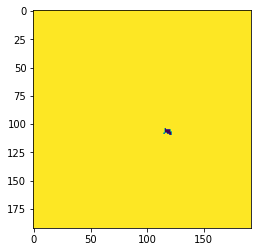

X_test 5


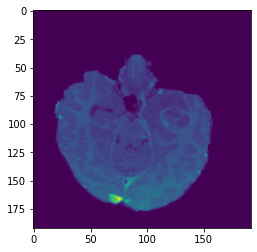

Predicted 5


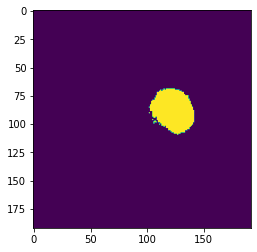

Actual 5


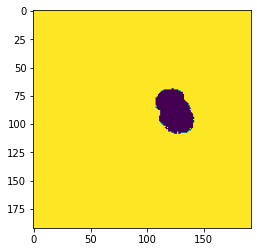

X_test 6


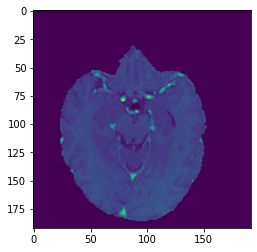

Predicted 6


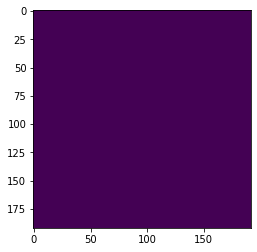

Actual 6


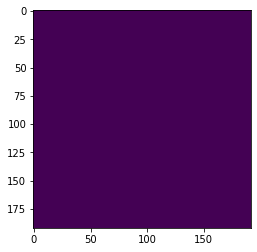

X_test 7


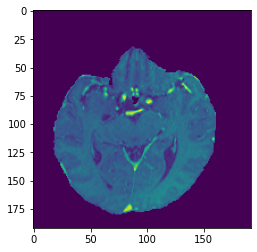

Predicted 7


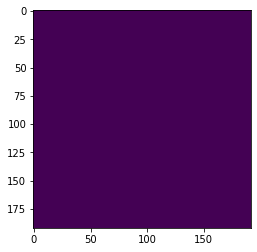

Actual 7


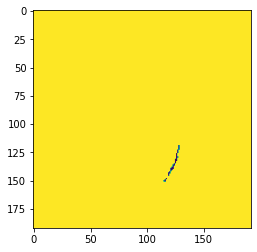

X_test 8


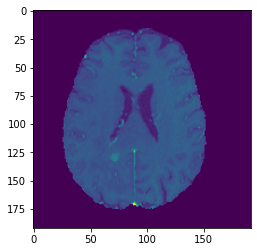

Predicted 8


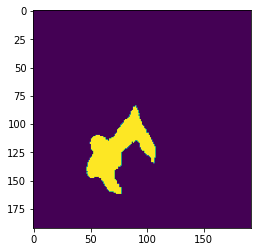

Actual 8


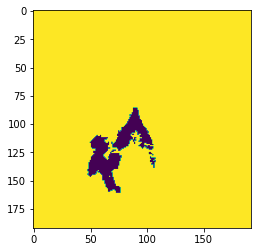

X_test 9


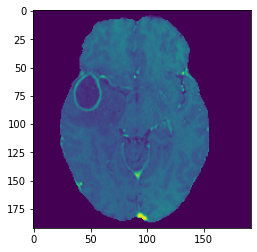

Predicted 9


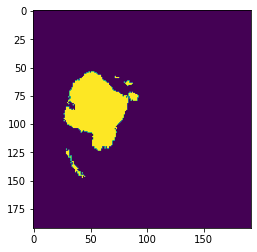

Actual 9


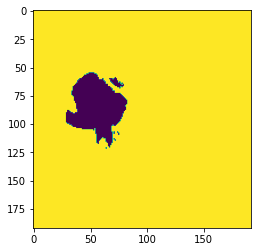

In [ ]:
for i in range(10):
  print('X_test '+ str(i))
  plt.imshow(X_train[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(pred[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_train[i,:,:,0])
  plt.show()

In [ ]:
print(days_train_enc)

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
print(age_train)

[56.419 39.068 51.734 ... 55.759 68.493 68.493]


In [ ]:
pred.shape

(1080, 192, 192, 1)

X_test 10


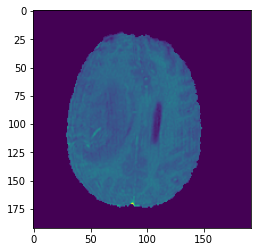

Predicted 10


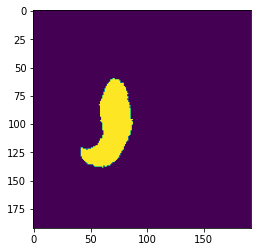

Actual 10


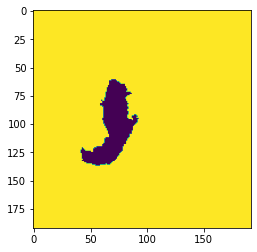

X_test 11


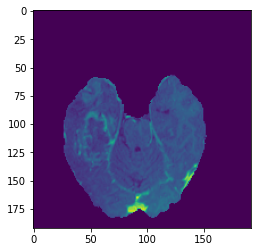

Predicted 11


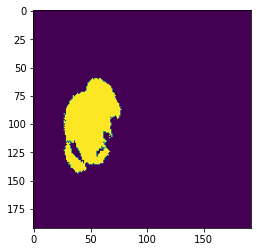

Actual 11


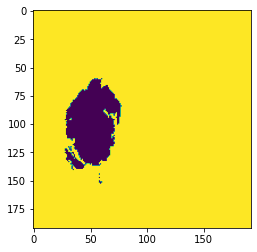

X_test 12


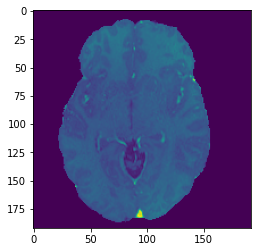

Predicted 12


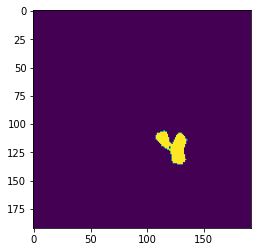

Actual 12


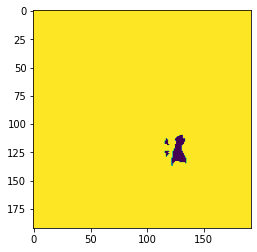

X_test 13


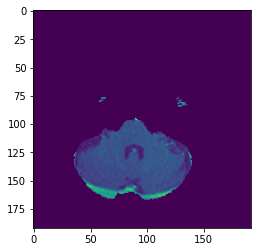

Predicted 13


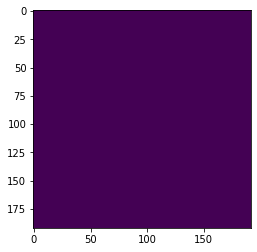

Actual 13


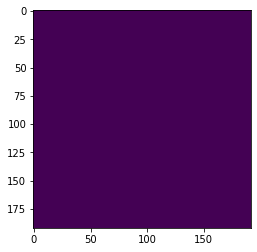

X_test 14


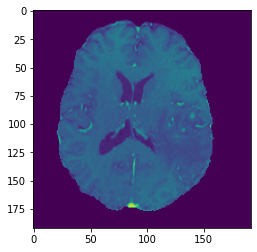

Predicted 14


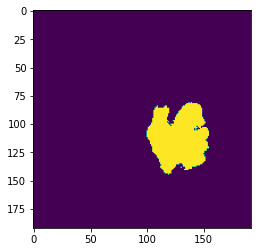

Actual 14


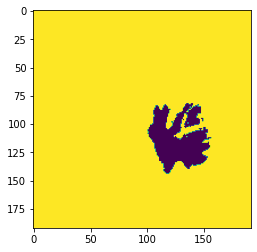

X_test 15


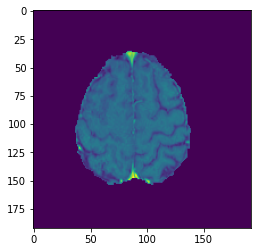

Predicted 15


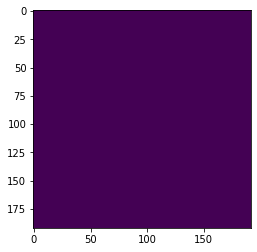

Actual 15


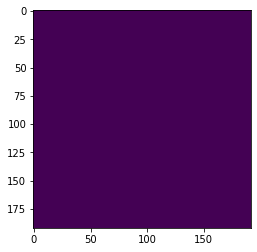

X_test 16


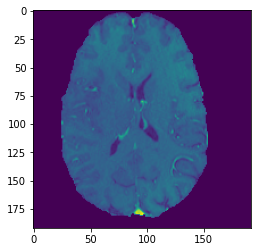

Predicted 16


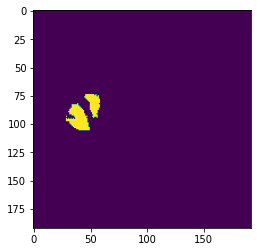

Actual 16


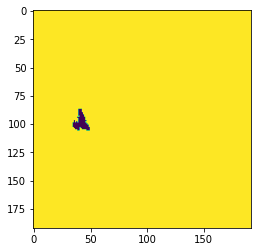

X_test 17


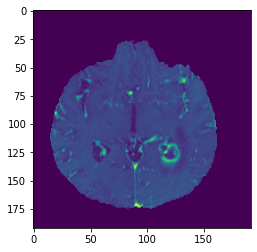

Predicted 17


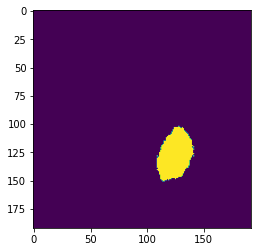

Actual 17


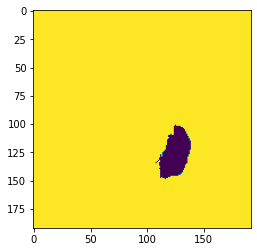

X_test 18


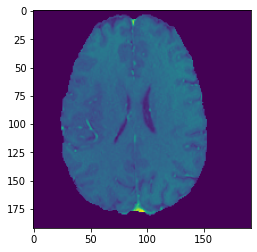

Predicted 18


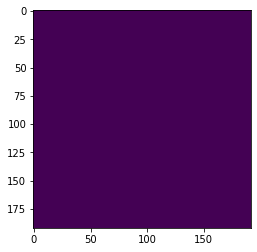

Actual 18


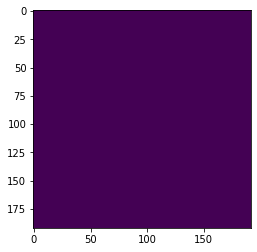

X_test 19


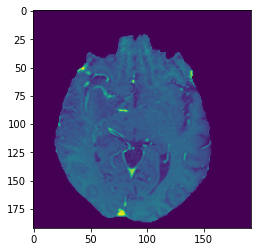

Predicted 19


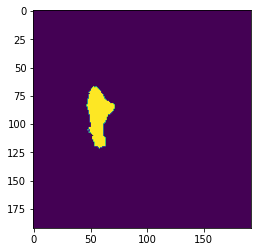

Actual 19


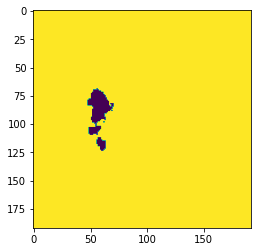

In [ ]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_train[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(pred[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_train[i,:,:,0])
  plt.show()

In [ ]:
history = model_surv.fit(x=[pred,age_train],y=days_train_enc, epochs = 20 , batch_size = 64)

Epoch 1/20
17/17 [==============================] - 38s 2s/step - loss: 0.7304 - accuracy: 0.7213
Epoch 2/20
17/17 [==============================] - 34s 2s/step - loss: 0.4933 - accuracy: 0.7972
Epoch 3/20
17/17 [==============================] - 34s 2s/step - loss: 0.4189 - accuracy: 0.8194
Epoch 4/20
17/17 [==============================] - 34s 2s/step - loss: 0.3473 - accuracy: 0.8417
Epoch 5/20
17/17 [==============================] - 34s 2s/step - loss: 0.3237 - accuracy: 0.8648
Epoch 6/20
17/17 [==============================] - 34s 2s/step - loss: 0.2989 - accuracy: 0.8620
Epoch 7/20
17/17 [==============================] - 34s 2s/step - loss: 0.2911 - accuracy: 0.8639
Epoch 8/20
17/17 [==============================] - 34s 2s/step - loss: 0.2724 - accuracy: 0.8796
Epoch 9/20
17/17 [==============================] - 34s 2s/step - loss: 0.2675 - accuracy: 0.8787
Epoch 10/20
17/17 [==============================] - 34s 2s/step - loss: 0.2759 - accuracy: 0.8685
Epoch 11/20
17/17 [

In [ ]:
model_surv.save('class_model.h5')

In [ ]:
Test_pre = np.argmax(seg.predict(X_test),axis=-1)

In [ ]:
np.unique(Test_pre)

array([0, 1, 2])

In [ ]:
Test_pred=Test_pre.reshape(-1,192,192,1)

In [ ]:
Test_pred.shape

(360, 192, 192, 1)

X_test 10


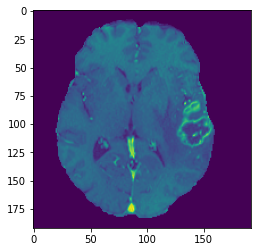

Predicted 10


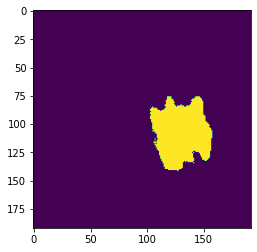

Actual 10


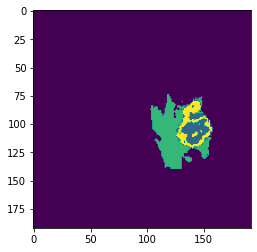

X_test 11


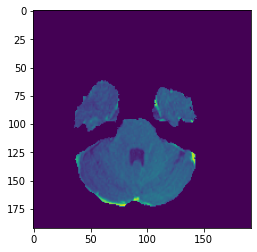

Predicted 11


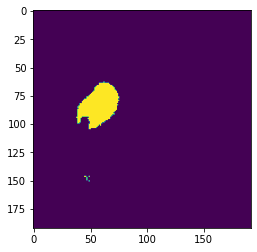

Actual 11


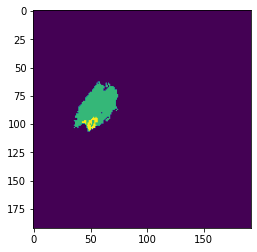

X_test 12


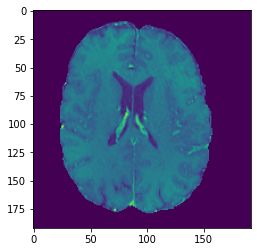

Predicted 12


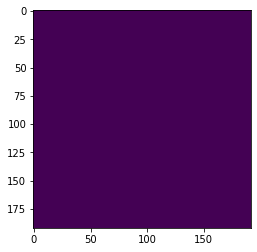

Actual 12


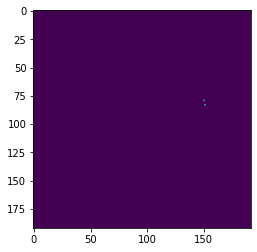

X_test 13


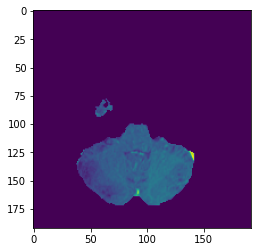

Predicted 13


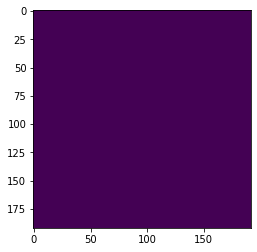

Actual 13


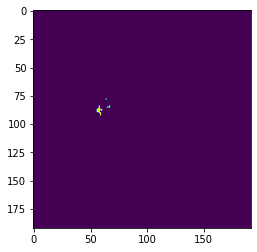

X_test 14


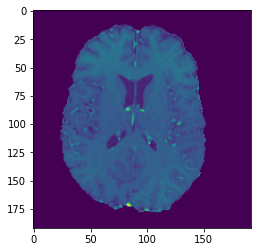

Predicted 14


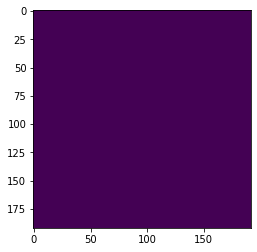

Actual 14


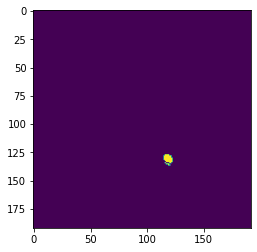

In [ ]:
for i in range(10,15):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Test_pred[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [ ]:
surv_model=load_model('class_model.h5' , custom_objects = {'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
scores = surv_model.evaluate(x = [Test_pred,age_test], y = days_test_enc)
prediction = surv_model.predict(x = [Test_pred,age_test])
prediction = np.argmax(prediction,axis = -1)
print(prediction)
ground_truth = np.argmax(days_test_enc,axis = -1)
print(ground_truth)
print(prediction == ground_truth)

12/12 [==============================] - 3s 258ms/step - loss: 0.3700 - accuracy: 0.8806
[0 1 2 2 1 1 0 0 1 0 1 1 2 1 2 1 2 0 0 2 2 2 2 2 0 2 0 0 0 0 2 1 0 0 0 0 1
 2 0 0 1 0 2 0 1 1 0 0 1 1 0 0 2 0 0 1 2 1 1 1 0 2 1 0 1 1 1 1 2 0 2 2 0 0
 0 0 0 2 0 0 1 1 2 2 1 0 2 2 0 2 1 0 0 2 2 0 2 2 0 0 0 0 0 1 2 2 0 0 2 2 1
 0 1 1 2 2 0 2 2 0 0 2 0 0 2 2 0 2 0 0 2 2 0 0 2 1 2 2 2 0 2 1 1 2 2 0 1 2
 2 2 1 2 2 2 0 1 2 2 2 1 2 1 0 1 2 2 2 0 0 2 2 2 2 1 1 1 0 0 2 0 1 0 2 0 1
 1 1 1 2 2 2 0 0 0 0 1 1 2 2 2 2 2 1 0 1 0 2 0 0 2 2 1 1 2 2 0 2 1 1 0 1 0
 0 1 2 2 1 2 0 2 2 0 1 2 2 1 1 1 0 0 1 1 0 2 0 0 0 0 1 0 1 0 1 2 2 0 0 2 0
 0 2 0 1 2 0 2 1 0 2 2 2 0 0 2 0 0 1 0 2 2 2 0 2 0 2 0 0 0 1 1 2 2 1 2 0 1
 2 0 0 2 1 0 2 2 0 2 1 1 2 0 0 2 2 0 0 1 2 1 2 0 0 0 0 2 0 1 0 1 0 1 1 1 2
 2 1 0 0 2 0 0 0 0 2 2 0 1 2 0 2 0 2 0 0 2 2 2 1 0 1 1]
[0 1 2 0 1 1 0 0 1 0 1 1 2 1 2 1 2 0 0 2 2 2 0 2 0 0 0 0 0 0 2 1 0 1 0 0 1
 2 0 0 1 0 2 0 2 1 1 0 1 1 0 0 2 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 2 0 2 0 0 2
 0 0 0 2 0 0 1 1 2 2 1 0 2 2 0

In [ ]:
model=load_model('vnet-model.h5',custom_objects = {'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
np.save('x_test.npy',X_test)
np.save('y_test.npy',Y_test)
np.save('x_train.npy',X_train)
np.save('y_train.npy',Y_train)

In [ ]:
tst=np.load('x_test.npy')

NameError: ignored

In [ ]:
yt=np.load('y_test.npy')

In [ ]:
res1=np.argmax(model.predict(tst),axis=-1)

In [ ]:
res1.shape

(360, 192, 192)

In [ ]:
np.unique(res1)

array([0, 1, 2])

In [ ]:
res1=res1.reshape(-1,192,192,1)

X_test 0


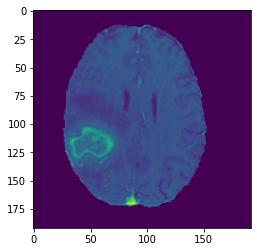

Predicted 0


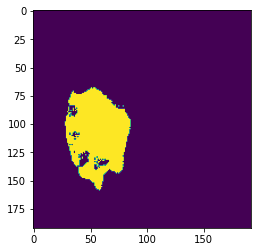

Actual 0


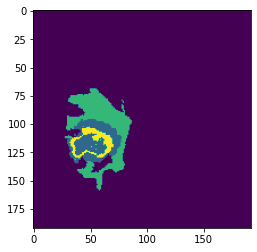

X_test 1


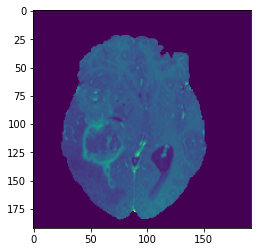

Predicted 1


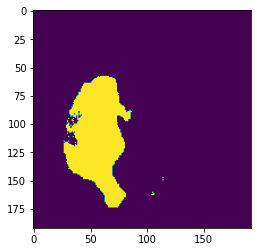

Actual 1


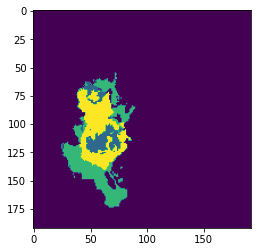

X_test 2


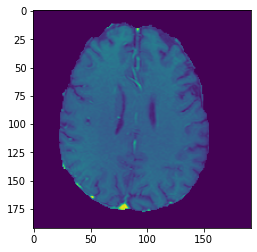

Predicted 2


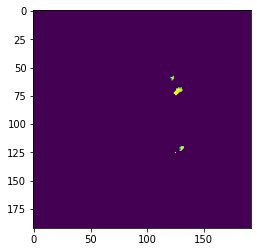

Actual 2


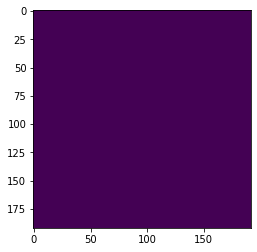

X_test 3


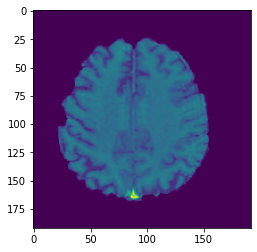

Predicted 3


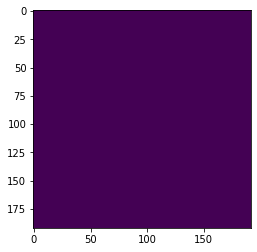

Actual 3


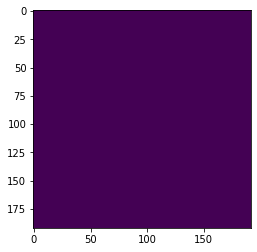

X_test 4


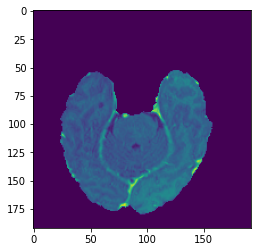

Predicted 4


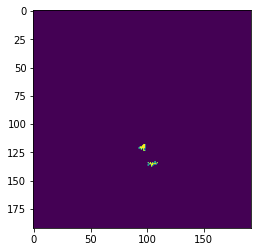

Actual 4


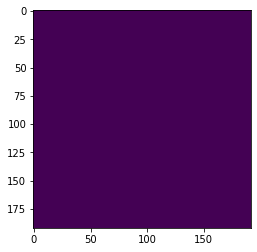

X_test 5


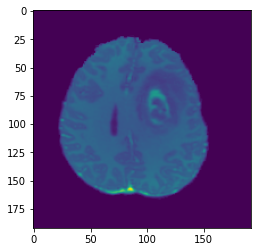

Predicted 5


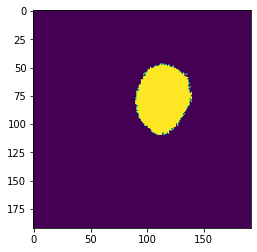

Actual 5


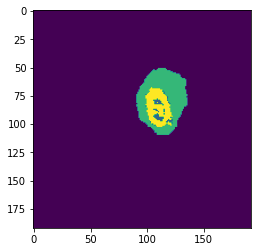

X_test 6


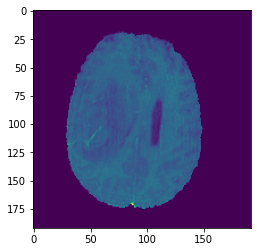

Predicted 6


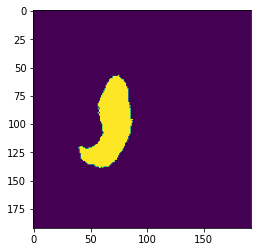

Actual 6


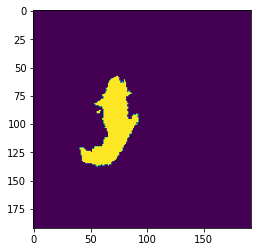

X_test 7


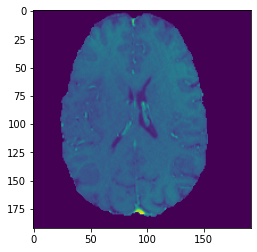

Predicted 7


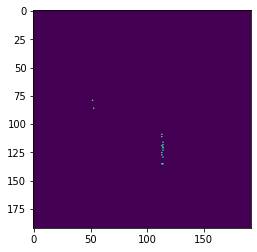

Actual 7


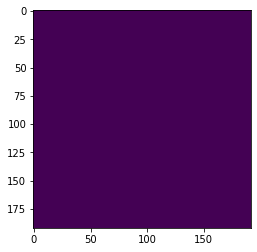

X_test 8


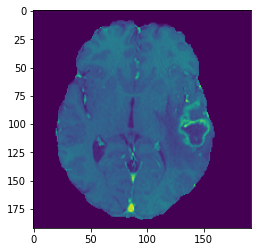

Predicted 8


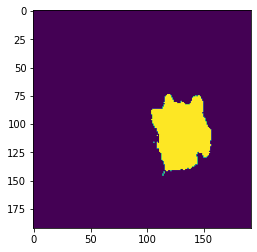

Actual 8


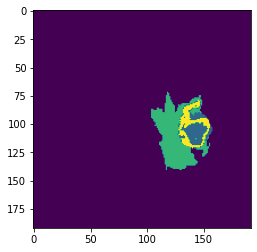

X_test 9


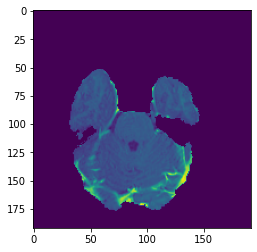

Predicted 9


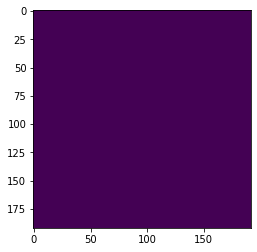

Actual 9


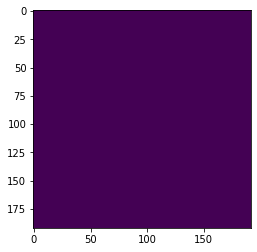

In [ ]:
for i in range(10):
  print('X_test '+ str(i))
  plt.imshow(tst[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(res1[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(yt[i,:,:,0])
  plt.show()

In [ ]:
surv=load_model('class_model.h5',custom_objects={'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
scores = surv.evaluate(x = [res1,age_test], y = days_test_enc)
pre = surv.predict(x = [res1,age_test])
pre = np.argmax(pre,axis = -1)
print(pre)
ground_truth = np.argmax(days_test_enc,axis = -1)
print(ground_truth)
print(prediction == ground_truth)

12/12 [==============================] - 3s 254ms/step - loss: 0.3700 - accuracy: 0.8806
[0 1 2 2 1 1 0 0 1 0 1 1 2 1 2 1 2 0 0 2 2 2 2 2 0 2 0 0 0 0 2 1 0 0 0 0 1
 2 0 0 1 0 2 0 1 1 0 0 1 1 0 0 2 0 0 1 2 1 1 1 0 2 1 0 1 1 1 1 2 0 2 2 0 0
 0 0 0 2 0 0 1 1 2 2 1 0 2 2 0 2 1 0 0 2 2 0 2 2 0 0 0 0 0 1 2 2 0 0 2 2 1
 0 1 1 2 2 0 2 2 0 0 2 0 0 2 2 0 2 0 0 2 2 0 0 2 1 2 2 2 0 2 1 1 2 2 0 1 2
 2 2 1 2 2 2 0 1 2 2 2 1 2 1 0 1 2 2 2 0 0 2 2 2 2 1 1 1 0 0 2 0 1 0 2 0 1
 1 1 1 2 2 2 0 0 0 0 1 1 2 2 2 2 2 1 0 1 0 2 0 0 2 2 1 1 2 2 0 2 1 1 0 1 0
 0 1 2 2 1 2 0 2 2 0 1 2 2 1 1 1 0 0 1 1 0 2 0 0 0 0 1 0 1 0 1 2 2 0 0 2 0
 0 2 0 1 2 0 2 1 0 2 2 2 0 0 2 0 0 1 0 2 2 2 0 2 0 2 0 0 0 1 1 2 2 1 2 0 1
 2 0 0 2 1 0 2 2 0 2 1 1 2 0 0 2 2 0 0 1 2 1 2 0 0 0 0 2 0 1 0 1 0 1 1 1 2
 2 1 0 0 2 0 0 0 0 2 2 0 1 2 0 2 0 2 0 0 2 2 2 1 0 1 1]
[0 1 2 0 1 1 0 0 1 0 1 1 2 1 2 1 2 0 0 2 2 2 0 2 0 0 0 0 0 0 2 1 0 1 0 0 1
 2 0 0 1 0 2 0 2 1 1 0 1 1 0 0 2 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 2 0 2 0 0 2
 0 0 0 2 0 0 1 1 2 2 1 0 2 2 0

In [ ]:
from keras.models import load_model
seg_u=load_model('unet-model.h5' , custom_objects = {'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
res2=np.argmax(seg_u.predict(tst),axis=-1)

In [ ]:
res2=res2.reshape(-1,192,192,1)

In [ ]:
res2.shape

(360, 192, 192, 1)

In [ ]:
np.unique(res2)

array([0, 1, 2, 3])

X_test 0


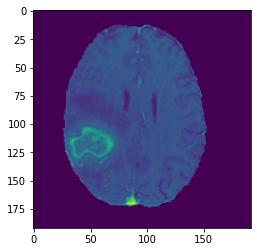

Predicted 0


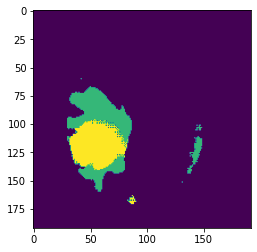

Actual 0


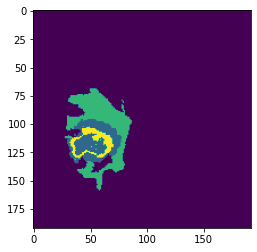

X_test 1


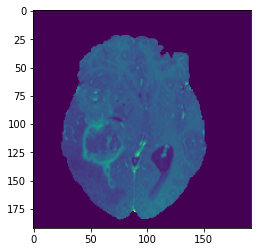

Predicted 1


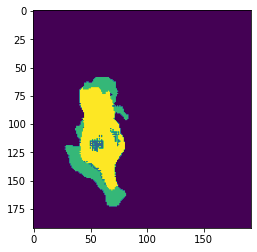

Actual 1


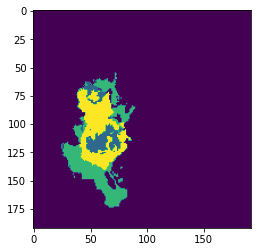

X_test 2


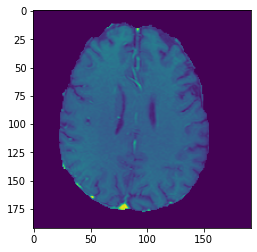

Predicted 2


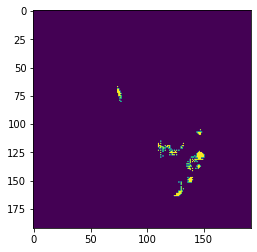

Actual 2


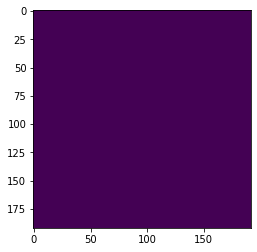

X_test 3


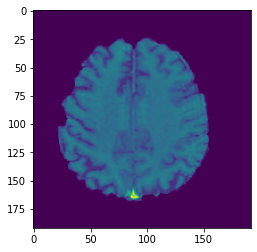

Predicted 3


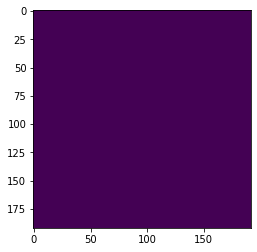

Actual 3


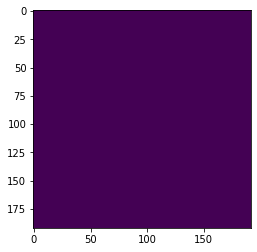

X_test 4


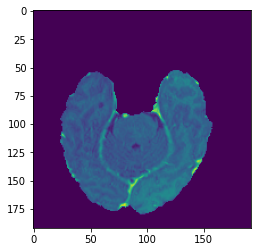

Predicted 4


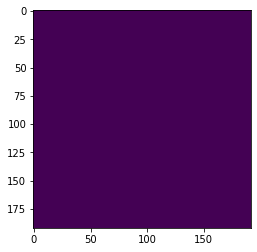

Actual 4


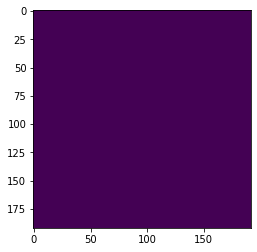

X_test 5


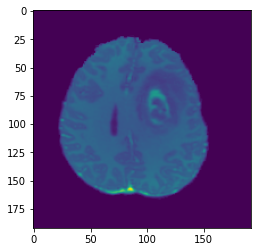

Predicted 5


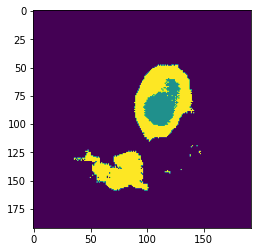

Actual 5


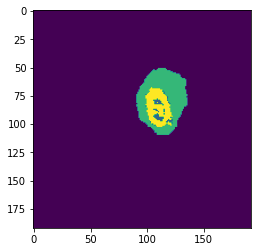

X_test 6


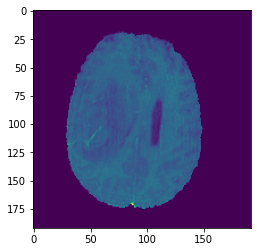

Predicted 6


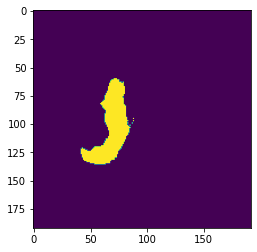

Actual 6


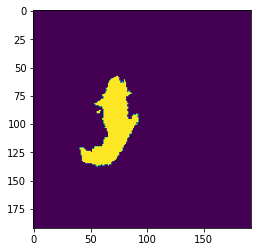

X_test 7


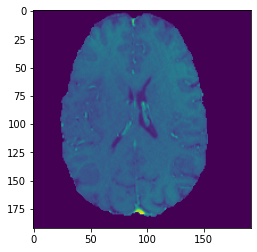

Predicted 7


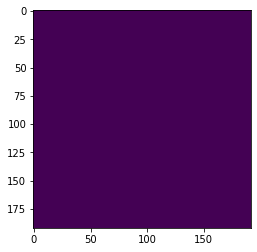

Actual 7


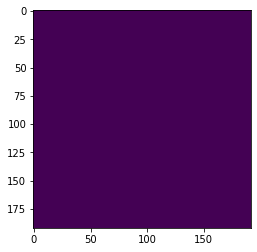

X_test 8


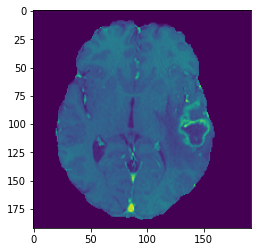

Predicted 8


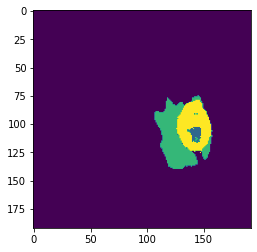

Actual 8


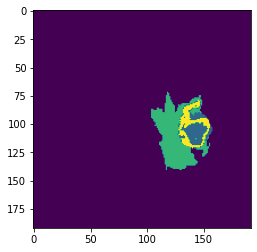

X_test 9


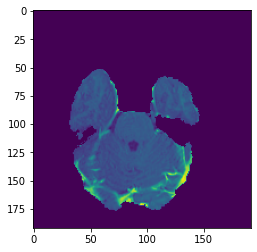

Predicted 9


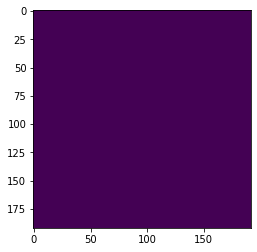

Actual 9


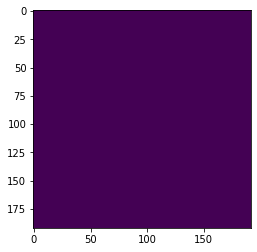

In [ ]:
for i in range(10):
  print('X_test '+ str(i))
  plt.imshow(tst[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(res2[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(yt[i,:,:,0])
  plt.show()

In [ ]:
scores = surv.evaluate(x = [res2,age_test], y = days_test_enc)
pre = surv.predict(x = [res2,age_test])
pre = np.argmax(pre,axis = -1)
print(pre)
ground_truth = np.argmax(days_test_enc,axis = -1)
print(ground_truth)
print(prediction == ground_truth)

12/12 [==============================] - 3s 242ms/step - loss: 0.7196 - accuracy: 0.7861
[1 1 2 2 0 1 0 0 1 0 0 1 2 1 2 0 2 1 0 2 2 2 0 2 0 2 0 0 0 1 2 1 0 0 0 0 1
 2 0 2 1 0 1 0 2 1 0 0 1 1 0 0 2 0 0 1 2 1 1 1 0 2 1 0 0 2 1 1 2 1 2 2 0 0
 0 0 0 2 0 0 1 1 2 0 1 0 2 2 0 0 2 0 0 2 0 2 2 2 0 0 0 0 0 1 2 2 2 0 2 2 1
 0 1 1 2 2 0 1 2 0 0 2 0 0 2 2 0 2 0 0 2 2 0 0 0 1 2 0 2 0 2 1 1 2 1 0 1 2
 2 2 1 2 2 2 0 1 2 2 0 1 2 1 0 1 2 2 2 0 1 2 2 0 0 1 1 1 1 0 2 0 1 0 2 0 1
 1 1 1 1 0 1 0 0 0 0 1 1 1 2 2 2 2 1 0 1 0 2 1 0 2 2 0 0 2 1 2 2 1 1 0 1 0
 0 1 0 2 1 2 0 2 0 0 1 2 1 1 1 0 0 0 2 0 0 2 0 0 0 0 1 0 1 0 1 2 2 0 0 0 0
 1 2 0 1 2 0 2 0 0 1 2 2 0 0 2 0 0 1 0 2 2 2 0 2 0 2 0 0 0 1 1 1 0 1 2 0 1
 0 0 0 2 1 0 0 2 0 2 1 1 1 0 0 2 2 0 0 1 2 1 2 0 0 0 0 2 0 1 0 1 0 1 1 1 2
 2 1 0 0 2 0 0 0 0 2 2 0 1 0 0 2 0 1 0 0 2 1 1 1 2 0 2]
[0 1 2 0 1 1 0 0 1 0 1 1 2 1 2 1 2 0 0 2 2 2 0 2 0 0 0 0 0 0 2 1 0 1 0 0 1
 2 0 0 1 0 2 0 2 1 1 0 1 1 0 0 2 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 2 0 2 0 0 2
 0 0 0 2 0 0 1 1 2 2 1 0 2 2 0

In [ ]:
import numpy as np
test=np.load('x_test.npy')
yt=np.load('y_test.npy')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/My Drive/')

ValueError: ignored

In [ ]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
from keras.models import load_model
Vm=load_model('vnet-model.h5',custom_objects = {'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})
Um=load_model('unet-model.h5',custom_objects = {'dice_coef_loss' :  dice_coef_loss , 'dice_coef' : dice_coef})

In [ ]:
test1=test[100]
yt=yt[100]

In [ ]:
pre_v = np.argmax(Vm.predict(test1.reshape(1,192,192,-1)),axis=-1)
pre_u = np.argmax(Um.predict(test1.reshape(1,192,192,-1)),axis=-1)

In [ ]:
pre_v=pre_v.reshape(-1,192,192,1)
pre_u=pre_u.reshape(-1,192,192,1)
# act=yt.reshape(-1,192,192,1)

In [ ]:
pre_v.shape,pre_u.shape,yt.shape

((1, 192, 192, 1), (1, 192, 192, 1), (192, 192, 1))

In [ ]:
test1.shape

(192, 192, 4)

In [ ]:
test1=test1.reshape(-1,192,192,4)

In [ ]:
test1.shape

(1, 192, 192, 4)

test


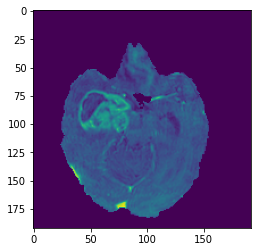

Unet Predicted 


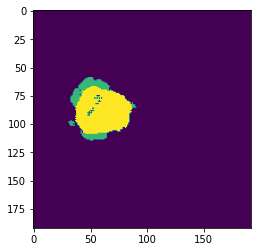

Vnet Predicted 


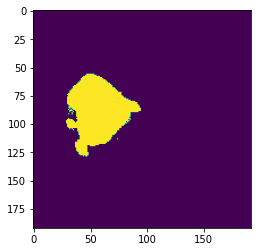

Actual


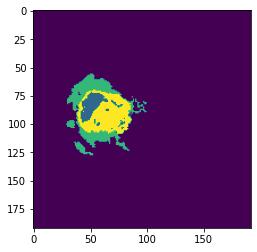

In [ ]:
import matplotlib.pyplot as plt
print('test')
plt.imshow(test1[0,:,:,2])
plt.show()

print('Unet Predicted ')
plt.imshow(pre_u[0,:,:,0])
plt.show()

print('Vnet Predicted ')
plt.imshow(pre_v[0,:,:,0])
plt.show()

print("Actual")
plt.imshow(yt[:,:,0])
plt.show()

In [ ]:
sur_m=load_model('class_model.h5')

In [ ]:
print(yt.shape)
age=yt[100][1]
# print(age)
age=np.asarray(age)
# age=age[0]
print(age)
age.shape

(192, 192, 1)
[0]


(1,)

In [ ]:
prediction = sur_m.predict([pre_u,age])
pred1 = np.argmax(prediction,axis = -1)
print("Unet survival prediction")
print(pred1)

if(pred1==0):
  print("short survivors(< 125 days)")
elif(pred1==1):
  print("medium surviors (< 200 days)")
else:
  print("long surviors (> 200 days)")

prediction2 = sur_m.predict([pre_v,age])
pred2 = np.argmax(prediction2,axis = -1)

print("Vnet survival prediction")
print(pred2)

if(pred2==0):
  print("short survivors(< 125 days)")
elif(pred2==1):
  print("medium surviors (< 200 days)")
else:
  print("long surviors (> 200 days)")

# ground_truth = yt[10][1]
# print(ground_truth)

Unet survival prediction
[0]
short survivors(< 125 days)
Vnet survival prediction
[0]
short survivors(< 125 days)


In [ ]:
import matplotlib.pyplot as plt

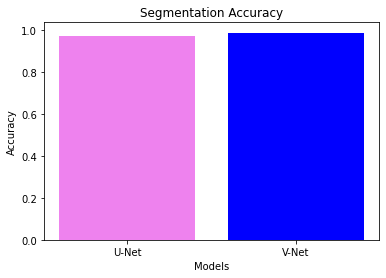

In [ ]:
a=['U-Net','V-Net']
b=[0.9743,0.9877]
#b = np.random.randint(low=0, high=100, size=10)
plt.bar(a,b, color=[ 'violet', 'blue'])
plt.xlabel('Models')
plt.ylabel("Accuracy")
plt.title('Segmentation Accuracy')
plt.show()

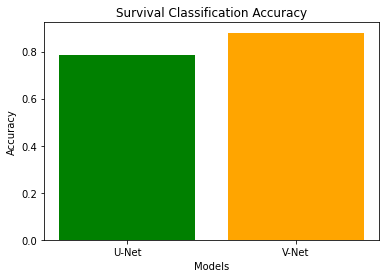

In [ ]:
a=['U-Net','V-Net']
b=[0.7861,0.880]
#b = np.random.randint(low=0, high=100, size=10)
plt.bar(a,b, color=[ 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel("Accuracy")
plt.title('Survival Classification Accuracy')
plt.show()

In [ ]:
cols = ['Loss', 'Accuracy']
rows = ['Unet', 'Vnet']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)